# Initial data exploration and structure

The purpose of this notebook is to explore and understand the structure and content of the Job Descriptions 2025 dataset.

**Main points**

* Assess the quality and completeness of the dataset.
* Examine the distribution of job categories (Tech vs. Non-Tech).
* Analyze the overall characteristics of the job descriptions, such as text length, vocabulary diversity, and common terms.
* Identify potential issues or insights that will guide the next steps in text preprocessing and NLP modeling.

# Configuration

In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

c:\Users\arual\Desktop\projects\Job_Descriptions_2025_NPL\src\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data

The information is stored in a json file.

In [2]:
# Download data from Kaggle
path = kagglehub.dataset_download("adityarajsrv/job-descriptions-2025-tech-and-non-tech-roles")

# Save in this repository
df_raw = pd.read_json(os.path.join(path, "job_dataset.json"))

# Data Exploration (EDA)

Now were are going to performe an EDA at table level. In the the fild `03_eda_language.ipynb` we will performe a more specific EDA, focus in the linguistic analyse.

## General information

We will take a look in the data structure: shape, nulls, duplacated

In [3]:
print(f"Rows: {df_raw.shape[0]:,} | Columns: {df_raw.shape[1]}")


Rows: 1,068 | Columns: 7


In [4]:
df_raw.sample(n=5, random_state=1)

,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords
457,13,Full Stack Developer - Experienced,Experienced,3–5 years,"[HTML5, CSS3, JavaScript, React, Angular, Vue....",[Develop and maintain full-stack applications ...,"[Full Stack Developer, Experienced, Mid-Level,..."
347,DS-F8,Fresher Data Scientist,Fresher,0-1,"[Python, R, SQL, Pandas, NumPy, Matplotlib, Se...","[Analyze small datasets to extract insights, B...","[Data Scientist, Python, R, SQL, Machine Learn..."
639,NE009,Network Intern,Fresher,0,"[DHCP, Subnetting, Cisco IOS, VPN Basics]","[Assist senior engineers on projects, Help con...","[Internship, Cisco IOS, Subnetting, DHCP]"
833,SRE-F-003,Site Reliability Engineer,Fresher,0-1,"[Python basics, Bash scripting basics, Linux a...","[Assist in setting up monitoring dashboards, S...","[Python, Bash, Linux, Docker, Kubernetes, AWS,..."
437,FE011,Frontend Developer - Experienced,Mid-Senior Level,3–6 years,"[HTML5, CSS3, JavaScript (ES6+), React/Redux, ...",[Design and develop advanced frontend applicat...,"[Frontend, Web Application Development, Mid-Se..."


In [5]:
df_raw.isnull().sum().sort_values(ascending=False)

Title                1
JobID                0
ExperienceLevel      0
YearsOfExperience    0
Skills               0
Responsibilities     0
Keywords             0
dtype: int64

In [6]:
# Duplicated only in the principal columns
duplicates = df_raw.duplicated(subset=(["Title", "JobID"])).sum()

print(f"Duplicated rows: {duplicates}")

Duplicated rows: 0


## Catgorical distribution

We are going to explore the count in each level for the categorical variables: ExperienceLevel, YearsOfExperience, Skills, Keywords

### Experience level

There are some equivalent categories. The idea is grop them into few labels.

In [7]:
print(df_raw["ExperienceLevel"].unique())

['Fresher' 'Experienced' 'Entry-Level' 'Mid-Senior Level' 'Senior-Level'
 'Mid-Level' 'Mid-Senior' 'Senior' 'Junior' 'Mid-level' 'Lead']


In [8]:
mapping = {
    "Fresher": "Entry",
    "Entry-Level": "Entry",
    "Junior": "Entry",

    "Mid-Level": "Mid",
    "Mid-level": "Mid",

    "Mid-Senior Level": "Mid-Senior",
    "Mid-Senior": "Mid-Senior",

    "Experienced": "Senior",
    "Senior-Level": "Senior",
    "Senior": "Senior",
    "Lead": "Senior",   
}

# New column
df_raw["ExperienceLevel_clean"] = (
    df_raw["ExperienceLevel"]
    .str.strip()
    .replace(mapping)
    .fillna("Other")
)

print(df_raw["ExperienceLevel_clean"].unique())

['Entry' 'Senior' 'Mid-Senior' 'Mid']


C:\Users\arual\AppData\Local\Temp\ipykernel_76892\1005270698.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


Text(0, 0.5, 'Experience Level')

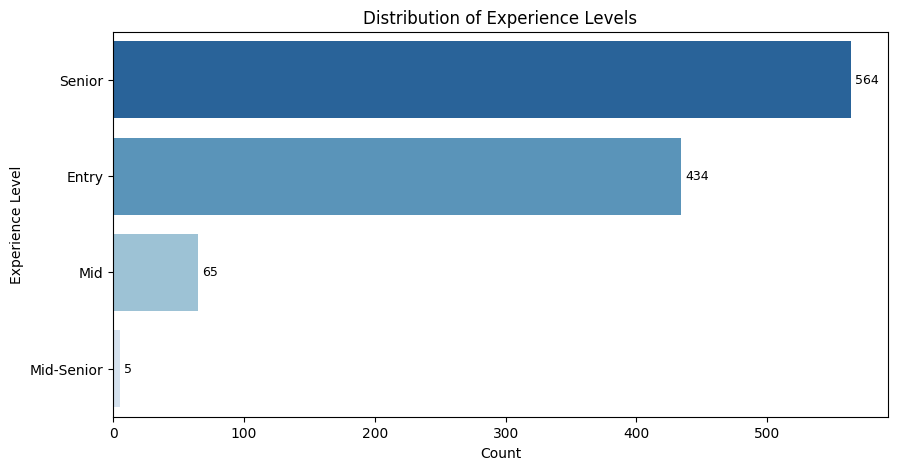

In [9]:
# ExperienceLevel_clean and YearsOfExperience

fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    y="ExperienceLevel_clean",
    data=df_raw,
    order=df_raw["ExperienceLevel_clean"].value_counts().index,
    ax=ax,
    palette="Blues_r"
)

# Add counts on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9, color='black')

ax.set_title("Distribution of Experience Levels")
ax.set_xlabel("Count")
ax.set_ylabel("Experience Level")

### Years Of Experience

The codification of this column is very mixed. As it is related with the level, we are going to explore both variables together in order to make a cetegorization

In [10]:
exp_summary = (
    df_raw
    .groupby(["ExperienceLevel_clean", "YearsOfExperience"])
    .size()
    .reset_index(name="Count")
    .sort_values(by=["ExperienceLevel_clean", "YearsOfExperience"])
)

exp_summary



,ExperienceLevel_clean,YearsOfExperience,Count
0,Entry,0,48
1,Entry,0-1,247
2,Entry,0-1 Years,10
3,Entry,0-2,25
4,Entry,0–1 year,104
...,...,...,...
112,Senior,8–10 years,1
113,Senior,9,2
114,Senior,9+,8
115,Senior,9-12,3


In [ ]:
def years_to_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    # limpiar texto
    s = re.sub(r'(?i)\byears?\b', '', s)  # quita 'year'/'years'
    s = s.replace('–', '-')               # normaliza en-dash
    s = re.sub(r'\s+', ' ', s).strip()    # colapsa espacios
    
    # tomar SIEMPRE el primer número que aparezca (rango 3-4 -> 3; 10+ -> 10)
    m = re.search(r'\d+(\.\d+)?', s)
    return float(m.group(0)) if m else np.nan

# aplicar
df_raw["Years_num"] = df_raw["YearsOfExperience"].apply(years_to_number)

# si prefieres enteros (manteniendo NaN):
df_raw["Years_num"] = pd.to_numeric(df_raw["Years_num"], errors="coerce").astype("Int64")



In [14]:
year_summary = (
    df_raw
    .groupby(["ExperienceLevel_clean", "Years_num"])
    .size()
    .reset_index(name="Count")
    .sort_values(by=["ExperienceLevel_clean", "Years_num"])
)

year_summary

,ExperienceLevel_clean,Years_num,Count
0,Entry,0,434
1,Mid,2,40
2,Mid,3,21
3,Mid,4,4
4,Mid-Senior,3,4
5,Mid-Senior,4,1
6,Senior,1,2
7,Senior,2,15
8,Senior,3,70
9,Senior,4,69


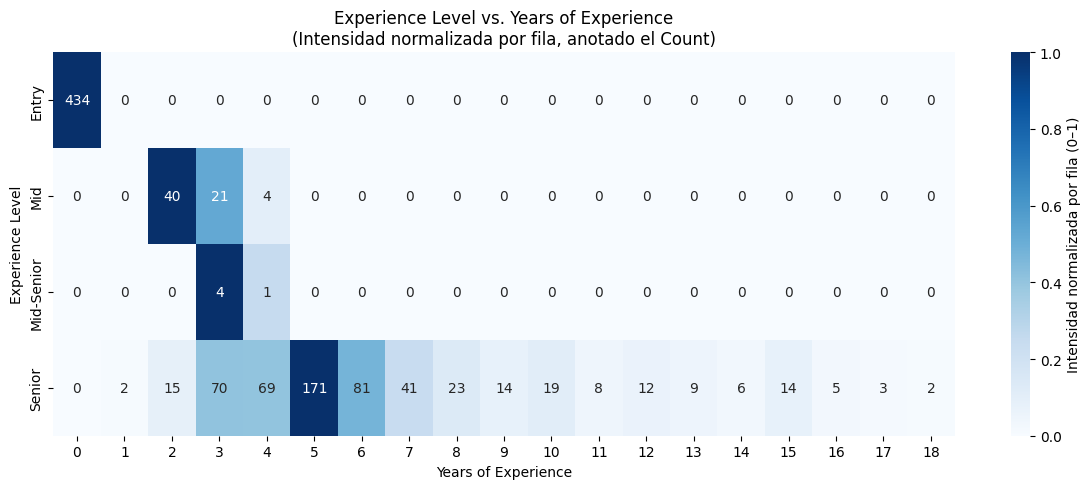

In [25]:

# Partimos de year_summary (ExperienceLevel_clean, Years_num, Count)
ys = year_summary.dropna(subset=["Years_num"]).copy()
ys["Years_num"] = ys["Years_num"].astype(int)

# Pivot de conteos
pivot_counts = (
    ys.pivot(index="ExperienceLevel_clean", columns="Years_num", values="Count")
      .fillna(0)
)

# Ordenar columnas (años) de menor a mayor
pivot_counts = pivot_counts.reindex(sorted(pivot_counts.columns), axis=1)

# Normalización por fila: cada fila se escala por su máximo (min-max row-wise)
row_max = pivot_counts.max(axis=1).replace(0, np.nan)  # evita división por 0
pivot_norm = pivot_counts.div(row_max, axis=0).fillna(0)

plt.figure(figsize=(12, 5))

# Heatmap usando valores normalizados (0–1) para el color
ax = sns.heatmap(
    pivot_norm,
    cmap="Blues",          # prueba también: "viridis", "rocket_r", "cividis"
    vmin=0, vmax=1,
    annot=pivot_counts.astype(int),  # anotamos el conteo real
    fmt="d",
    cbar_kws={"label": "Intensidad normalizada por fila (0–1)"}
)

ax.set_title("Experience Level vs. Years of Experience\n(Intensidad normalizada por fila, anotado el Count)")
ax.set_xlabel("Years of Experience")
ax.set_ylabel("Experience Level")
plt.tight_layout()
plt.show()


Now is easier explore





3️⃣ Distribución de categorías

Número de registros por Job Category, Industry, Job Title.

Visualización (barras o donut chart) de Tech vs Non-Tech.

Conteo de descripciones por país o región si existe la columna.

4️⃣ Longitud y estructura del texto

Histograma de longitud de descripciones (len(text.split())).

Detección de textos vacíos o extremadamente cortos/largos.

Boxplot de longitud por categoría.

5️⃣ Primer vistazo léxico

Nube de palabras por categoría (sin limpieza profunda todavía).

Top 30 palabras más frecuentes por tipo de rol.

Distribución de longitud media de palabras y frases.

6️⃣ Insights iniciales

Diferencias lingüísticas básicas entre Tech y Non-Tech.

Observaciones sobre calidad del dataset (ej. descripciones repetidas o incompletas).

Recomendaciones para el notebook siguiente (02_cleaning.ipynb).

7️⃣ Guardado de resultados

Exportar dataset limpio sin duplicados a data/processed/exploration_base.csv.

Guardar algunas métricas iniciales (ej. summary_stats.json).